In [3]:
import pandas as pd
import itertools
import networkx as nx
from collections import Counter

df_tracks = pd.read_csv("DATA/spotify_genius_data.csv")

G_artists = nx.Graph()
artist_collab_counts = Counter()

for artists_str in df_tracks["artists"].dropna():
    artists = [a.strip() for a in artists_str.split(",")]
    for artist in artists:
        G_artists.add_node(artist)
    for a1, a2 in itertools.combinations(artists, 2):
        pair = tuple(sorted((a1, a2)))
        artist_collab_counts[pair] += 1


G_artists.add_weighted_edges_from( # add edges with weights
    [(a1, a2, w) for (a1, a2), w in artist_collab_counts.items()]
)


#############
# Calculate average popularity and first release year for each artist
pop_sum   = Counter()
pop_count = Counter()
first_release = {}

for _, row in df_tracks.iterrows():
    if pd.isna(row["artists"]):
        continue
    artists = [a.strip() for a in row["artists"].split(",")]
    pop = row.get("popularity", 0) or 0
    try:
        year = pd.to_datetime(row["release_date"]).year
    except:
        year = None
    for artist in artists:
        pop_sum[artist]   += pop
        pop_count[artist] += 1
        if year and (artist not in first_release or year < first_release[artist]):
            first_release[artist] = year
avg_popularity = {
    artist: pop_sum[artist] / pop_count[artist]
    for artist in pop_sum
}
###############

for artist in G_artists.nodes():
    G_artists.nodes[artist]["display_name"] = artist
    G_artists.nodes[artist]["total_popularity"] = avg_popularity.get(artist, 0)
    G_artists.nodes[artist]["first_release_year"] = first_release.get(artist)
    G_artists.nodes[artist]["num_collaborations"] = G_artists.degree(artist, weight="weight")

In [4]:
print("Number of unique artists (nodes):", G_artists.number_of_nodes())
print("Number of collaborations (edges):", G_artists.number_of_edges())

degrees = dict(G_artists.degree(weight='weight'))
avg_degree = sum(degrees.values()) / len(degrees)
print("Average (weighted) degree:", round(avg_degree, 2))

Number of unique artists (nodes): 418
Number of collaborations (edges): 696
Average (weighted) degree: 4.54


In [5]:
top5_degree = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 artists by number of collaborations:")
for artist, degree in top5_degree:
    print(f"  {artist:30} collaborations: {degree}")


Top 5 artists by number of collaborations:
  David Guetta                   collaborations: 55
  Anne-Marie                     collaborations: 45
  Bebe Rexha                     collaborations: 45
  Drake                          collaborations: 42
  RAYE                           collaborations: 38


In [6]:
avg_pop_dict = nx.get_node_attributes(G_artists, "total_popularity")
top5_popularity = sorted(avg_pop_dict.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 artists by average popularity:")
for artist, avg_pop in top5_popularity:
    print(f"  {artist:30} avg popularity: {avg_pop:.2f}")


Top 5 artists by average popularity:
  ROSÉ                           avg popularity: 96.00
  The Chainsmokers               avg popularity: 89.00
  Anitta                         avg popularity: 88.00
  Wizkid                         avg popularity: 88.00
  Kyla                           avg popularity: 88.00


In [7]:
release_dict = nx.get_node_attributes(G_artists, "first_release_year")
top5_earliest = sorted(release_dict.items(), key=lambda x: x[1] if x[1] else 9999)[:5]
print("\nTop 5 artists with earliest first release:")
for artist, year in top5_earliest:
    print(f"  {artist:30} first release year: {year}")


Top 5 artists with earliest first release:
  Beyoncé                        first release year: 2003
  JAY-Z                          first release year: 2003
  Sean Paul                      first release year: 2003
  Rihanna                        first release year: 2005
  Jonas Brothers                 first release year: 2007


In [8]:
from networkx.algorithms import community

# Detect communities
communities = list(community.greedy_modularity_communities(G_artists, weight="weight"))

print(f"\nDetected {len(communities)} communities.")
print("Top 5 largest communities by number of artists:")
for i, c in enumerate(sorted(communities, key=len, reverse=True)[:5]):
    print(f"  Community {i+1}: {len(c)} artists")


Detected 24 communities.
Top 5 largest communities by number of artists:
  Community 1: 56 artists
  Community 2: 52 artists
  Community 3: 42 artists
  Community 4: 36 artists
  Community 5: 30 artists


In [10]:
# Sort communities by size (descending)
sorted_communities = sorted(communities, key=len, reverse=True)

# Get top 5 community subgraphs
top_5_community_graphs = [
    G_artists.subgraph(c).copy() for c in sorted_communities[:5]
]

# Example: show basic stats for each
for i, G_sub in enumerate(top_5_community_graphs, 1):
    print(f"\nCommunity {i}:")
    print(f"  Size: {G_sub.number_of_nodes()} artists")
    print(f"  Collaborations: {G_sub.number_of_edges()}")
    
    top_artists = sorted(G_sub.degree(weight='weight'), key=lambda x: x[1], reverse=True)[:5]
    print("  Top artists by degree:")
    for artist, deg in top_artists:
        print(f"    {artist:25} degree: {deg}")


Community 1:
  Size: 56 artists
  Collaborations: 93
  Top artists by degree:
    David Guetta              degree: 47
    Anne-Marie                degree: 40
    Bebe Rexha                degree: 37
    Ava Max                   degree: 18
    Clean Bandit              degree: 16

Community 2:
  Size: 52 artists
  Collaborations: 78
  Top artists by degree:
    Drake                     degree: 38
    Nicki Minaj               degree: 26
    Beyoncé                   degree: 18
    Rihanna                   degree: 16
    Sam Smith                 degree: 14

Community 3:
  Size: 42 artists
  Collaborations: 72
  Top artists by degree:
    Camila Cabello            degree: 32
    Justin Bieber             degree: 15
    Ed Sheeran                degree: 12
    Shawn Mendes              degree: 10
    Justin Timberlake         degree: 6

Community 4:
  Size: 36 artists
  Collaborations: 57
  Top artists by degree:
    Ariana Grande             degree: 19
    The Weeknd               

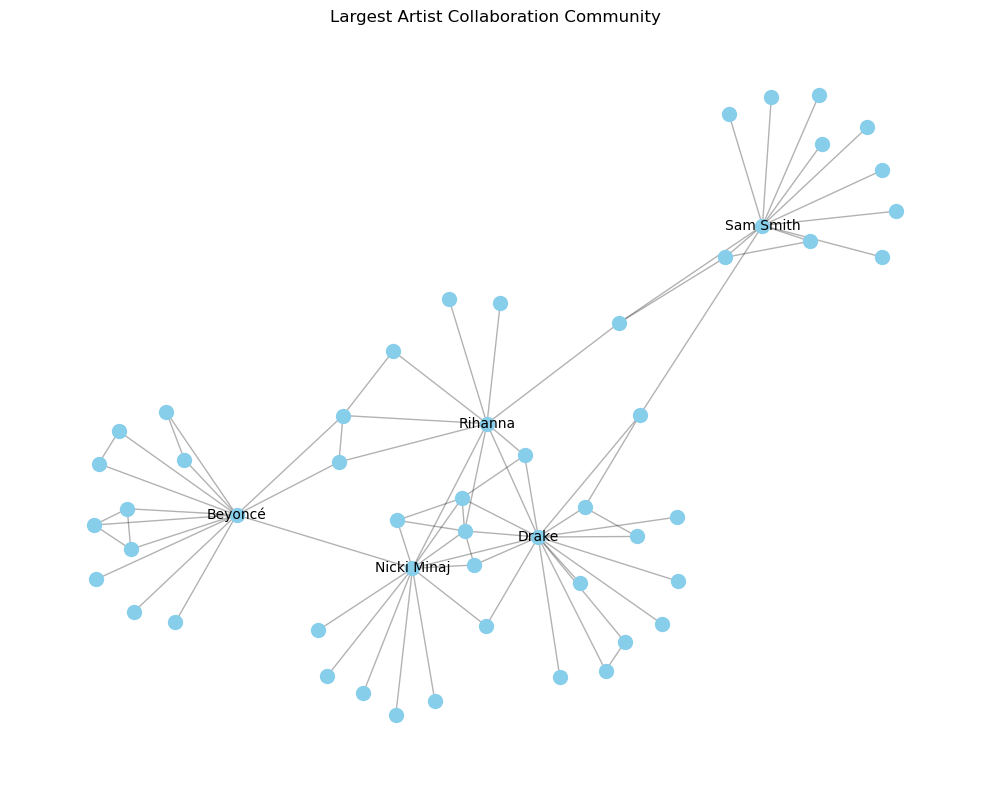

In [16]:
import matplotlib.pyplot as plt

G_comm = top_5_community_graphs[1]  # visualize the largest community

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_comm, seed=42)  # layout for better spacing

# Draw nodes and edges
nx.draw_networkx_nodes(G_comm, pos, node_size=100, node_color='skyblue')
nx.draw_networkx_edges(G_comm, pos, alpha=0.3)

# Optional: show names for top nodes
top_nodes = sorted(G_comm.degree(weight='weight'), key=lambda x: x[1], reverse=True)[:5]
top_labels = {node: node for node, _ in top_nodes}
nx.draw_networkx_labels(G_comm, pos, labels=top_labels, font_size=10)

plt.title("Largest Artist Collaboration Community")
plt.axis('off')
plt.tight_layout()
plt.show()

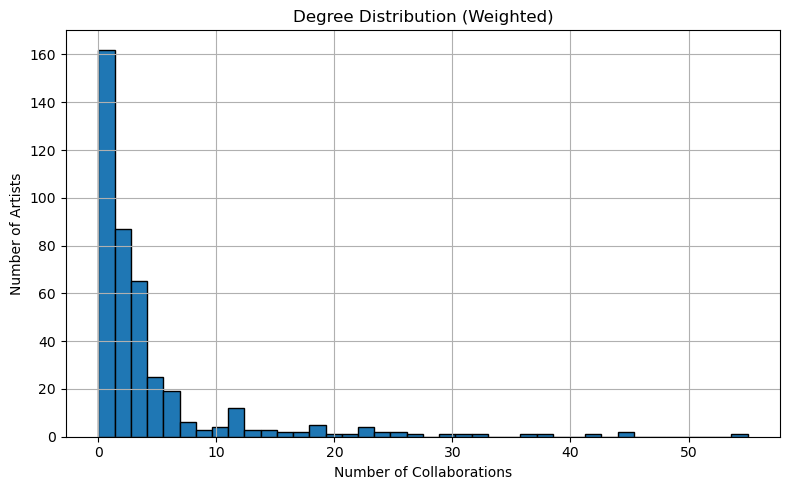

In [9]:
import matplotlib.pyplot as plt

# Get all weighted degrees
weighted_degrees = [deg for _, deg in G_artists.degree(weight='weight')]

plt.figure(figsize=(8, 5))
plt.hist(weighted_degrees, bins=40, edgecolor='black')
plt.title("Degree Distribution (Weighted)")
plt.xlabel("Number of Collaborations")
plt.ylabel("Number of Artists")
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
nx.write_gexf(G_artists, "artist_collaboration_network.gexf")

In [18]:
G = nx.read_gexf("DATA/artist_collaboration_network.gexf")
pos = nx.spring_layout(G, dim=3, seed=42)  # 3D layout

# Export nodes with label info
nodes = []
for node, coords in pos.items():
    label = G.nodes[node].get("display_name", node)
    size = G.nodes[node].get("num_collaborations", 1)
    nodes.append({
        "id": node,
        "x": coords[0],
        "y": coords[1],
        "z": coords[2],
        "label": label,
        "size": size
    })

df_nodes = pd.DataFrame(nodes)
df_nodes.to_csv("nodes.csv", index=False)

# Export edges
edges = [{"source": u, "target": v} for u, v in G.edges()]
df_edges = pd.DataFrame(edges)
df_edges.to_csv("edges.csv", index=False)